# Elephant Detection and GPS Localization Demo 🐘📍

Welcome! This Colab notebook allows you to upload a single drone image, detect elephants within it using a YOLO model, and estimate their GPS coordinates.

**How to use:**
1.  Run the "Setup" cell to install necessary libraries and download the model.
2.  Run the "Upload Image" cell and select a JPG image from your computer.
3.  Run the "Process Image and Get Results" cell. This will perform detection, calculate GPS, and display the results.
4.  The results (image with IDs, coordinates CSV, distances CSV) will be displayed and made available for download.

---
## 1. Setup Environment

In [1]:
# Install necessary packages
!pip install ultralytics piexif geopy pyproj -q
!apt-get install -y exiftool -qq

# Import necessary libraries
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import pandas as pd
import time
import os
from pathlib import Path
import matplotlib.pyplot as plt
from pyproj import Transformer
import math
import re
from datetime import datetime, timedelta
import subprocess
import json
import csv
from google.colab import files
from PIL import Image
import io
from geopy.distance import geodesic
from IPython.display import Image as IPImage, display

# Create output directories
os.makedirs("Detections", exist_ok=True)
os.makedirs("Processed_Output", exist_ok=True)

print("\nSetup Complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00
Selecting previously unselected package libarchive-zip-perl.
(Reading database ... 126109 files and directories currently inst


##  Upload Model

In [2]:
print("Please upload 'best_xl.pt':")
uploaded_model = files.upload()
if 'best_xl.pt' not in uploaded_model:
  print("\nERROR: 'best_xl.pt' was not uploaded. Please upload the model file to proceed.")
else:
  print("\nModel 'best_xl.pt' uploaded successfully!")

Please upload 'best_xl.pt':


Saving best_xl.pt to best_xl.pt

Model 'best_xl.pt' uploaded successfully!


---
## 2. Upload Your Image

Please upload a single JPG image:


Saving DJI_0396.JPG to DJI_0396.JPG

Loaded and saved image: DJI_0396.JPG


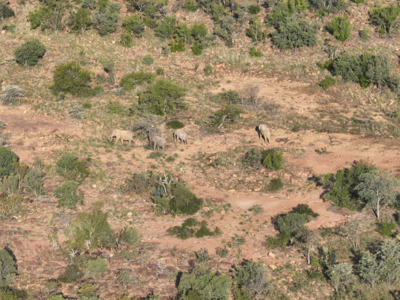

In [3]:
from google.colab import files
import io
from PIL import Image

# Upload image
print("Please upload a single JPG image:")
uploaded = files.upload()

# Load and save the uploaded image
uploaded_image_path = None
for fn in uploaded.keys():
    if fn.lower().endswith('.jpg') or fn.lower().endswith('.jpeg'):
        uploaded_image_path = f"/content/{fn}"
        with open(uploaded_image_path, 'wb') as f:
            f.write(uploaded[fn])
        print(f"\nLoaded and saved image: {fn}")

        # Display the uploaded image
        img_display = Image.open(io.BytesIO(uploaded[fn]))
        img_display.thumbnail((400, 400)) # Resize for display
        display(img_display)
        break # Process only the first uploaded JPG

if not uploaded_image_path:
    print("\nERROR: No JPG image was uploaded. Please run this cell again and upload a valid image.")

---
## 3. Process Image and Get Results

INFO: Using Sensor Size 17.3mm x 13.0mm (Mavic 3 Pro Main Cam).
Starting processing for: /content/DJI_0396.JPG
Running detection on /content/DJI_0396.JPG...
Detection complete. Found 4 objects. Saved to Detections/DJI_0396.txt.
Waiting for file: Detections/DJI_0396.txt...
File found: Detections/DJI_0396.txt
Loading bounding boxes from Detections/DJI_0396.txt...
Loaded 4 bounding boxes.

--- Starting GPS Pipeline ---
Extracting metadata...
Running exiftool...
exiftool successful.
  RelativeAltitude: +85.000
  *** ALTITUDE WARNING ***: Using RelativeAltitude. This is likely height above *takeoff*. If terrain is uneven, this will cause significant GPS errors. For high accuracy, ensure this value represents Above Ground Level (AGL) or implement DEM lookup.
  GimbalPitch: -16.7
  GimbalYaw: +167.80
  GimbalRoll: +0.00
  FocalLength: 29.85
  Lens Distortion Data: Not explicitly found (may still exist in MakerNotes).
Metadata extraction successful.
  Camera Intrinsics (K): fx=6901.7, fy=6888.

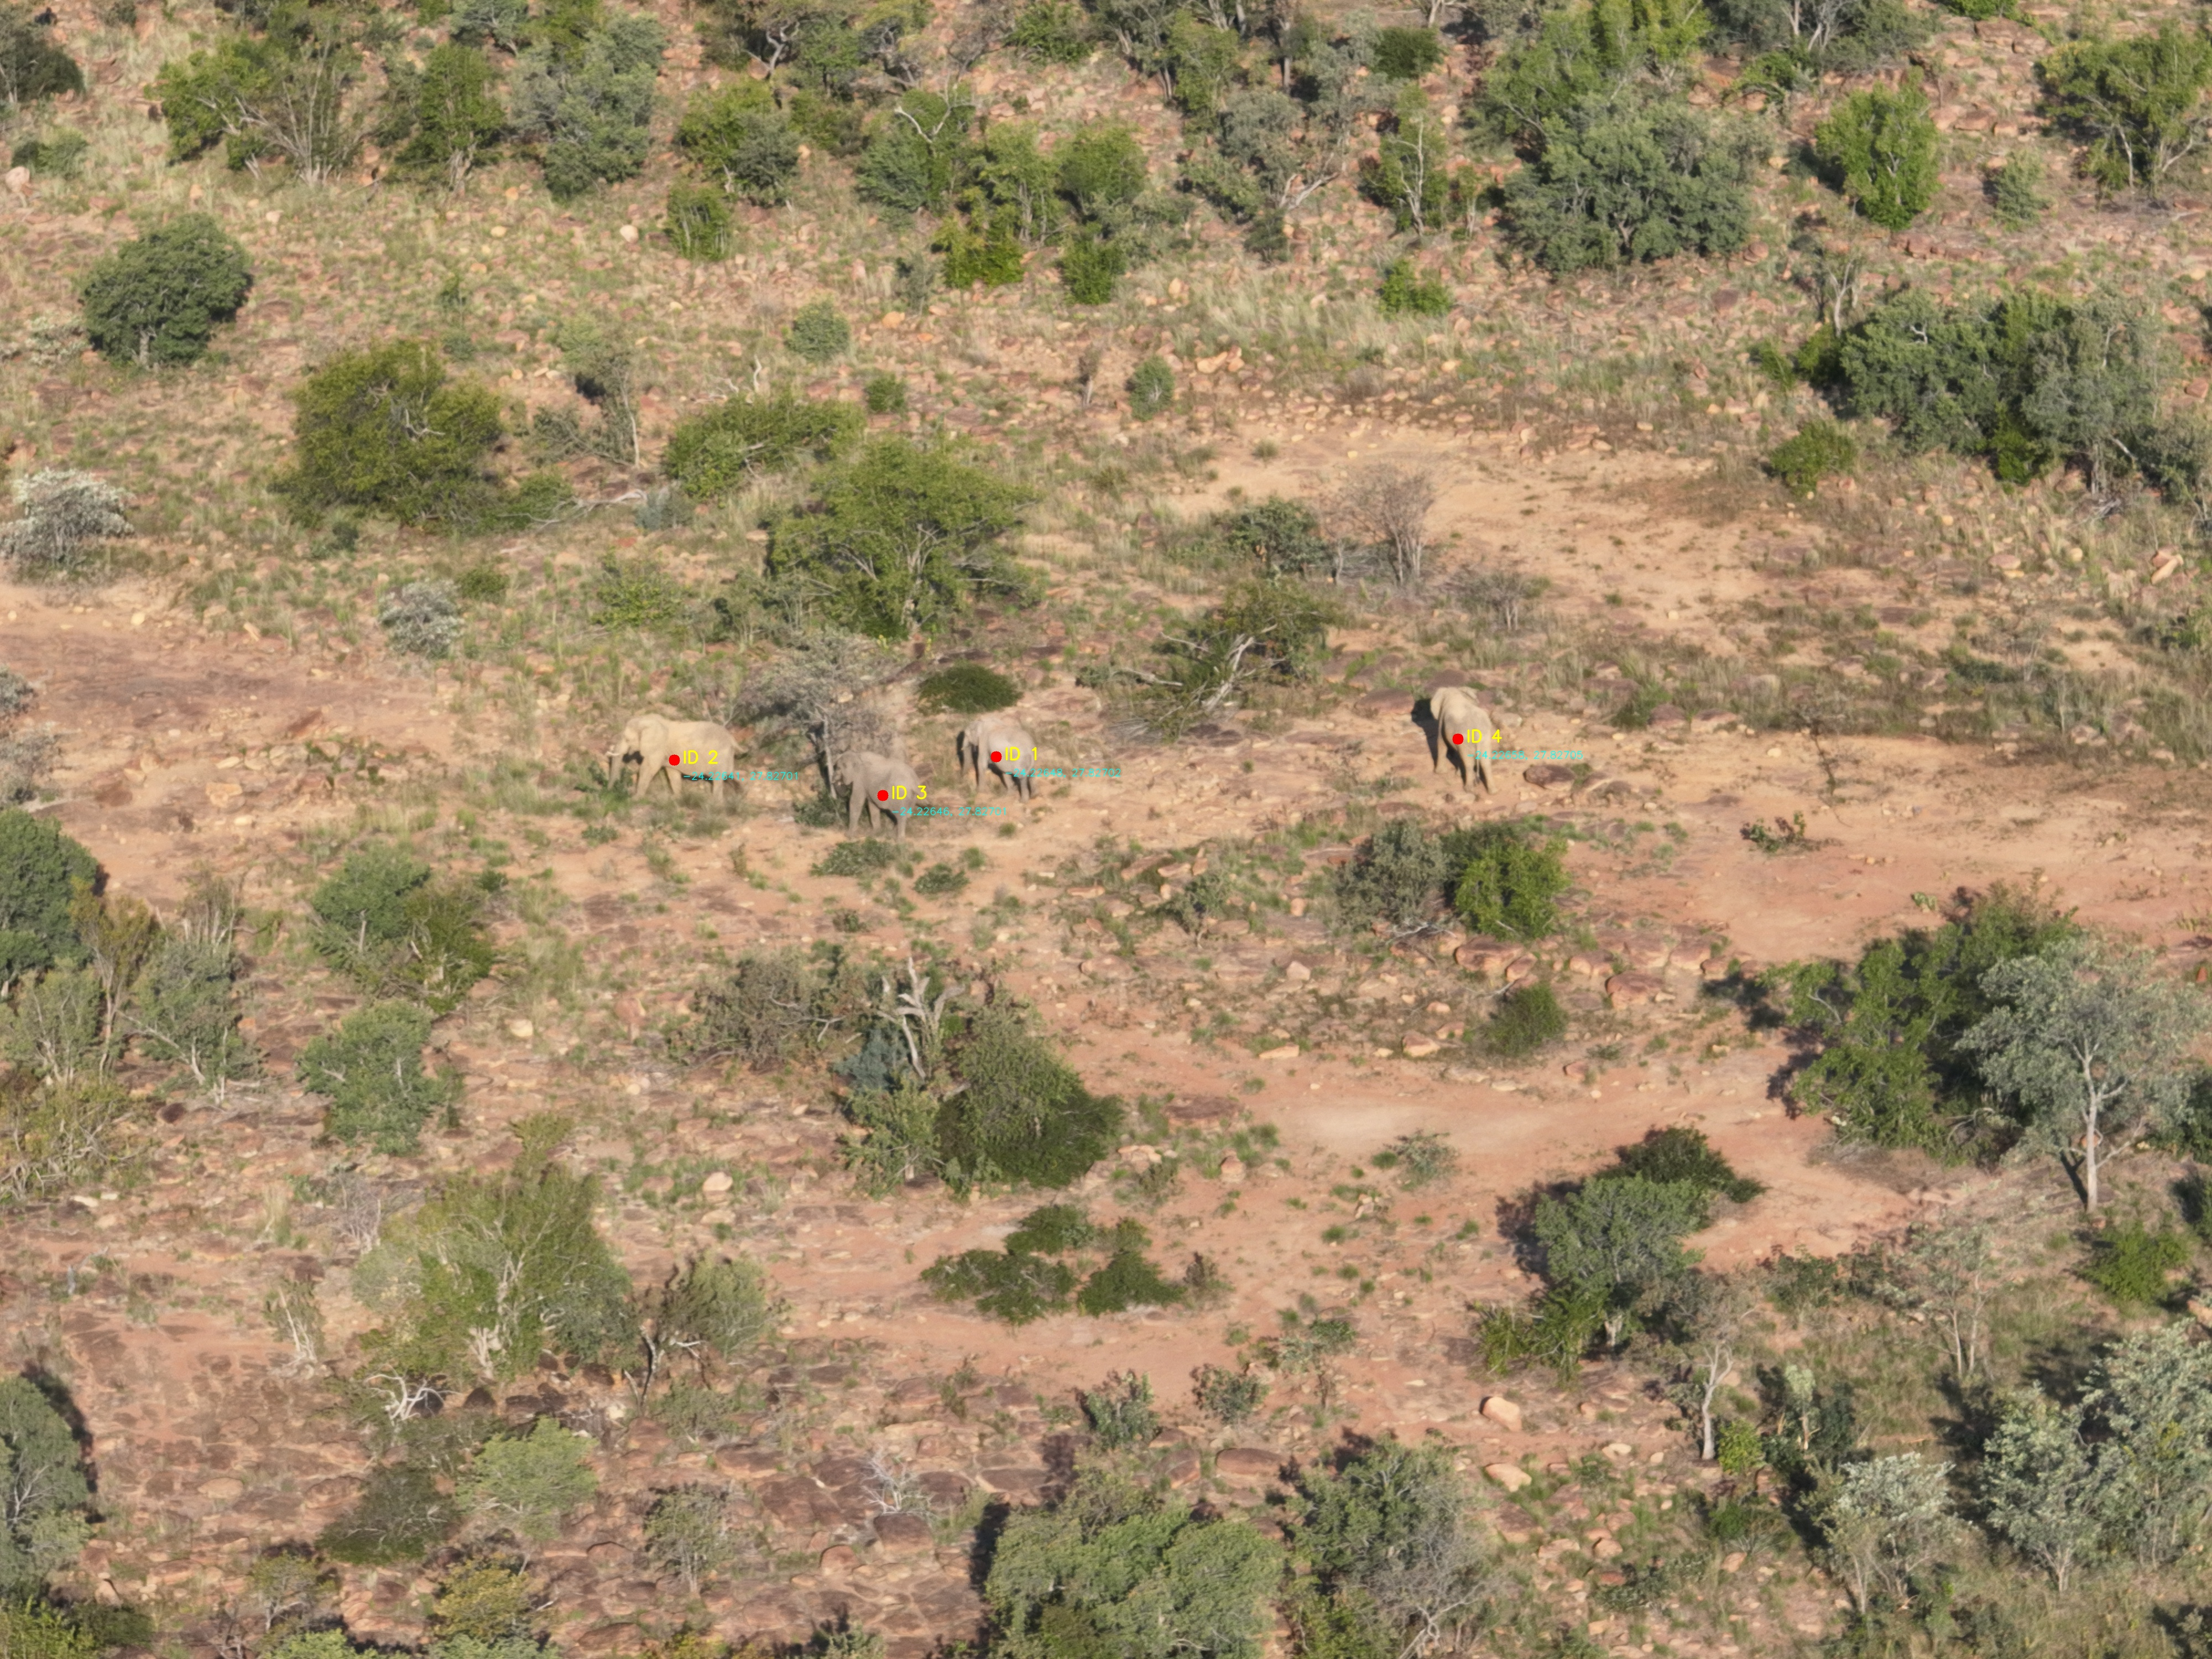


--- Download Links --- 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# --- Import Libraries ---
import os
import cv2
import numpy as np
import subprocess
import json
import re
import math
import time
import traceback
import csv
from pathlib import Path

# --- Dependencies Check ---
try:
    from ultralytics import YOLO
    from geopy.distance import geodesic
    from geopy.point import Point
    from IPython.display import display, Image as IPImage
except ImportError as e:
    print(f"ERROR: Missing dependency - {e}. Please install required libraries.")
    print("Run: pip install ultralytics opencv-python pyproj geopy ipython")
    exit()

# --- Global Configuration ---
OUTPUT_DIR_DETECTIONS = "Detections"
OUTPUT_DIR_PROCESSED = "Processed_Output"
MODEL_PATH = "best_xl.pt"

# --- SENSOR CONFIGURATION ---
# DJI Mavic 3 Pro MAIN HASSELBLAD camera. MUST CHANGE IF USING TELEPHOTO.
SENSOR_WIDTH_MM = 17.3
SENSOR_HEIGHT_MM = 13.0
print(f"INFO: Using Sensor Size {SENSOR_WIDTH_MM}mm x {SENSOR_HEIGHT_MM}mm (Mavic 3 Pro Main Cam).")

os.makedirs(OUTPUT_DIR_DETECTIONS, exist_ok=True)
os.makedirs(OUTPUT_DIR_PROCESSED, exist_ok=True)


# --- Define Helper Functions ---

def Find_Elephants(image_path):
    """Detects elephants using YOLO, saves detections."""
    if not os.path.exists(MODEL_PATH):
        print(f"ERROR: Model file '{MODEL_PATH}' not found.")
        return None, None
    try:
        model = YOLO(MODEL_PATH)
        print(f"Running detection on {image_path}...")
        results = model.predict(source=image_path, conf=0.6, verbose=False)
        im1 = cv2.imread(image_path)
        if im1 is None: raise FileNotFoundError(f"Could not read image: {image_path}")
        height, width, _ = im1.shape
        base_name = Path(image_path).stem
        yolo_format_data = []
        num_objects = 0

        for box in results[0].boxes:
            num_objects += 1
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            x1, y1, x2, y2 = map(float, box.xyxy[0])
            cv2.rectangle(im1, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(im1, f'Class: {cls}, Conf: {conf:.2f}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            xmin_norm, ymin_norm, xmax_norm, ymax_norm = x1/width, y1/height, x2/width, y2/height
            yolo_format_data.append(f"{cls} {conf:.6f} {xmin_norm:.6f} {ymin_norm:.6f} {xmax_norm:.6f} {ymax_norm:.6f}")

        output_image_path = os.path.join(OUTPUT_DIR_DETECTIONS, f"{base_name}_detection.jpg")
        output_txt_path = os.path.join(OUTPUT_DIR_DETECTIONS, f"{base_name}.txt")
        cv2.imwrite(output_image_path, im1)
        with open(output_txt_path, 'w') as f: f.write("\n".join(yolo_format_data))
        print(f"Detection complete. Found {num_objects} objects. Saved to {output_txt_path}.")
        return output_txt_path, output_image_path
    except Exception as e:
        print(f"ERROR during elephant detection: {e}")
        traceback.print_exc()
        return None, None

def extract_exiftool_metadata(image_path):
    """Extracts metadata using exiftool."""
    try:
        print("Running exiftool...")
        result = subprocess.run(['exiftool', '-j', '-n', '-G', image_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=True)
        print("exiftool successful.")
        return json.loads(result.stdout)[0]
    except FileNotFoundError: raise RuntimeError("ERROR: 'exiftool' not found. Is it installed and in PATH?")
    except subprocess.CalledProcessError as e: raise RuntimeError(f"exiftool failed: {e.stderr}")
    except Exception as e: raise RuntimeError(f"ERROR processing exiftool output: {e}")

def dms_to_decimal(dms_val, ref):
    """Converts DMS to decimal degrees."""
    if isinstance(dms_val, (int, float)): decimal = float(dms_val)
    else:
        match = re.search(r'(\d+)[^0-9.]*(\d*)[^0-9.]*([\d.]+)', str(dms_val).strip(), re.IGNORECASE)
        if not match: raise ValueError(f"Invalid DMS format: {dms_val}")
        degrees, minutes, seconds = match.groups()
        decimal = float(degrees) + (float(minutes) if minutes else 0.0)/60 + float(seconds)/3600
    if ref and ref.upper() in ['S', 'W']: decimal = -decimal
    return decimal

def get_metadata_value(metadata, keys, default=None):
    """Safely gets a value from metadata trying multiple keys."""
    for key in keys:
        value = metadata.get(key)
        if value is not None: return value
    return default

def extract_metadata(image_path):
    """Extracts and processes essential metadata."""
    print("Extracting metadata...")
    metadata = extract_exiftool_metadata(image_path)

    rel_alt_val = get_metadata_value(metadata, ['XMP:RelativeAltitude', 'EXIF:RelativeAltitude'])
    pitch_val = get_metadata_value(metadata, ['XMP:GimbalPitchDegree', 'EXIF:GimbalPitchDegree', 'Composite:GimbalPitch'])
    yaw_val = get_metadata_value(metadata, ['XMP:GimbalYawDegree', 'EXIF:GimbalYawDegree', 'Composite:GimbalYaw'], default=0.0)
    roll_val = get_metadata_value(metadata, ['XMP:GimbalRollDegree', 'EXIF:GimbalRollDegree', 'Composite:GimbalRoll'], default=0.0)
    focal_len_val = get_metadata_value(metadata, ['EXIF:FocalLength']) # Prefer actual EXIF:FocalLength
    img_width_val = get_metadata_value(metadata, ['EXIF:ImageWidth', 'File:ImageWidth'])
    img_height_val = get_metadata_value(metadata, ['EXIF:ImageHeight', 'File:ImageHeight'])
    gps_lat_val = get_metadata_value(metadata, ['EXIF:GPSLatitude', 'Composite:GPSLatitude'])
    gps_lon_val = get_metadata_value(metadata, ['EXIF:GPSLongitude', 'Composite:GPSLongitude'])
    gps_lat_ref = get_metadata_value(metadata, ['EXIF:GPSLatitudeRef'])
    gps_lon_ref = get_metadata_value(metadata, ['EXIF:GPSLongitudeRef'])

    # --- Altitude Warning ---
    print(f"  RelativeAltitude: {rel_alt_val}")
    print("  *** ALTITUDE WARNING ***: Using RelativeAltitude. This is likely height above *takeoff*. If terrain is uneven, this will cause significant GPS errors. For high accuracy, ensure this value represents Above Ground Level (AGL) or implement DEM lookup.")

    print(f"  GimbalPitch: {pitch_val}")
    print(f"  GimbalYaw: {yaw_val}")
    print(f"  GimbalRoll: {roll_val}")
    print(f"  FocalLength: {focal_len_val}")

    essential = {'RelativeAltitude': rel_alt_val, 'GimbalPitch': pitch_val, 'FocalLength': focal_len_val, 'ImageWidth': img_width_val, 'ImageHeight': img_height_val, 'GPSLatitude': gps_lat_val, 'GPSLongitude': gps_lon_val}
    missing = [k for k, v in essential.items() if v is None]
    if missing: raise ValueError(f"Missing essential EXIF tags: {missing}")

    # --- Check for Lens Distortion Data (For Info/Future Use) ---
    dewarp_data = get_metadata_value(metadata, ['XMP:DewarpData', 'XMP:PerspectiveDistortion'])
    if dewarp_data:
        print(f"  Lens Distortion Data Found (XMP): {str(dewarp_data)[:100]}...")
        print("  *** LENS DISTORTION WARNING ***: Distortion data found but *not currently used*. For higher accuracy, implement lens distortion correction (e.g., using cv2.undistortPoints with these parameters).")
    else:
        print("  Lens Distortion Data: Not explicitly found (may still exist in MakerNotes).")

    rel_alt = float(rel_alt_val)
    pitch_deg, yaw_deg, roll_deg = float(pitch_val), float(yaw_val), float(roll_val)
    focal_length_mm = float(str(focal_len_val).split(' ')[0])
    img_width, img_height = int(img_width_val), int(img_height_val)
    latitude = dms_to_decimal(gps_lat_val, gps_lat_ref)
    longitude = dms_to_decimal(gps_lon_val, gps_lon_ref)

    print("Metadata extraction successful.")
    return (latitude, longitude, rel_alt, pitch_deg, yaw_deg, roll_deg, focal_length_mm, SENSOR_WIDTH_MM, SENSOR_HEIGHT_MM, img_width, img_height)

def get_camera_intrinsics(f_mm, s_w_mm, s_h_mm, i_w, i_h):
    """Calculates camera intrinsic matrix K (Pinhole Model)."""
    fx = i_w * f_mm / s_w_mm
    fy = i_h * f_mm / s_h_mm
    cx, cy = i_w / 2, i_h / 2
    print(f"  Camera Intrinsics (K): fx={fx:.1f}, fy={fy:.1f}, cx={cx:.1f}, cy={cy:.1f}")
    return np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

def get_rotation_matrix(pitch_deg, yaw_deg, roll_deg):
    """
    Calculates the rotation matrix R from Camera to World (NED) frame.
    *** CRITICAL VALIDATION NEEDED ***
    This function now makes these assumptions:
    1.  It aims to output a NED (North, East, Down) frame.
    2.  Pitch: -90° = Down, 0° = Horizontal. We use it directly.
    3.  Yaw: 0° = North, 90° = East.
    4.  Roll: 0° = Level.
    5.  Rotation Order: Yaw, then Pitch, then Roll (Z-Y-X). This is a *guess*.
    *** YOU MUST VALIDATE THE N/E MAPPING and order. ***
    """
    print(f"  Using Angles (YPR): Yaw={yaw_deg:.2f}, Pitch={pitch_deg:.2f}, Roll={roll_deg:.2f}")

    # Convert degrees to radians - NO +90 adjustment, assuming NED output
    pitch = math.radians(pitch_deg)
    yaw = math.radians(yaw_deg)
    roll = math.radians(roll_deg)

    R_x = np.array([[1, 0, 0],
                    [0, math.cos(roll), -math.sin(roll)],
                    [0, math.sin(roll), math.cos(roll)]])

    R_y = np.array([[math.cos(pitch), 0, math.sin(pitch)],
                    [0, 1, 0],
                    [-math.sin(pitch), 0, math.cos(pitch)]])

    R_z = np.array([[math.cos(yaw), -math.sin(yaw), 0],
                    [math.sin(yaw), math.cos(yaw), 0],
                    [0, 0, 1]])

    # Combine rotations: ZYX order (Yaw -> Pitch -> Roll)
    R = R_z @ R_y @ R_x
    print("  Rotation Matrix (R) calculated. WARNING: Assumed NED output. Validate outputs!")
    return R

def calculate_destination_gps(origin_lat, origin_lon, east_m, north_m):
    """Calculates destination WGS84 using geopy."""
    if east_m is None or north_m is None: return None, None
    try:
        bearing = math.degrees(math.atan2(east_m, north_m))
        if bearing < 0: bearing += 360
        distance_meters = math.hypot(east_m, north_m)
        destination = geodesic(meters=distance_meters).destination(Point(origin_lat, origin_lon), bearing)
        return destination.latitude, destination.longitude
    except Exception as e:
        print(f"ERROR calculating destination GPS: {e}")
        return None, None

def image_point_to_gps(u, v, K, R, cam_h, o_lat, o_lon):
    """
    Projects an image point (u, v) to ground GPS coordinates.
    Assumes R outputs in a NED (North, East, Down) frame.
    """
    pixel = np.array([u, v, 1])
    K_inv = np.linalg.inv(K)
    ray_cam = K_inv @ pixel
    ray_world = R @ ray_cam # Vector in world (NED) coordinates

    # --- MODIFIED HORIZON CHECK (NED Frame) ---
    # In NED, Z is Down. If Z is zero or negative, it points at or above horizon.
    if ray_world[2] <= 1e-6: # Use a small tolerance
        print(f"  Warning: Point ({u},{v}) projects at/above horizon (Z_Down={ray_world[2]:.4f}), skipping.")
        return None, None

    # --- MODIFIED SCALING (NED Frame) ---
    # Ground plane is at Z = +cam_h (Down). P = scale * ray_world.
    # cam_h = scale * ray_world[2] => scale = cam_h / ray_world[2]
    scale = cam_h / ray_world[2]
    ground_point = ray_world * scale # Point in NED [North, East, Down]

    # --- AXIS MAPPING (NEEDS VALIDATION!) ---
    # We ASSUME ground_point = [North, East, Down].
    # calculate_destination_gps expects (East, North).
    # If your validation shows E/N are swapped or inverted, modify these lines:
    ned_n = ground_point[0]  # Assumed North
    ned_e = ground_point[1]  # Assumed East

    # --- Validation Examples (Uncomment ONE line below if needed) ---
    # ned_n, ned_e = ground_point[1], ground_point[0]  # Try if N/E Swapped
    # ned_n, ned_e = -ground_point[0], ground_point[1] # Try if N Inverted
    # ned_n, ned_e = ground_point[0], -ground_point[1] # Try if E Inverted
    # --- END VALIDATION EXAMPLES ---

    print(f"    -> NED offsets (m): N={ned_n:.2f}, E={ned_e:.2f}")

    # Pass East, then North to the calculation function
    return calculate_destination_gps(o_lat, o_lon, ned_e, ned_n)

def run_pipeline(image_path, bounding_boxes):
    """Runs the main processing pipeline."""
    print("\n--- Starting GPS Pipeline ---")
    try:
        meta = extract_metadata(image_path)
        lat, lon, alt, pitch, yaw, roll, f_mm, s_w, s_h, i_w, i_h = meta
    except Exception as e:
        print(f"FATAL ERROR extracting metadata: {e}. Cannot proceed.")
        return None

    K = get_camera_intrinsics(f_mm, s_w, s_h, i_w, i_h)
    R = get_rotation_matrix(pitch, yaw, roll)
    gps_results = []
    print("\nCalculating GPS for each bounding box (middle-center)...")

    for i, box in enumerate(bounding_boxes, start=1):
        xmin_norm, ymin_norm, xmax_norm, ymax_norm = box

        # --- Using Middle-Center Point ---
        center_u_norm = (xmin_norm + xmax_norm) / 2
        center_v_norm = (ymin_norm + ymax_norm) / 2 # <-- Changed back

        center_u = center_u_norm * i_w
        center_v = center_v_norm * i_h

        print(f"  Processing Box {i} at ({center_u:.1f}, {center_v:.1f})...") # <-- Changed back

        try:
            gps_lat, gps_lon = image_point_to_gps(center_u, center_v, K, R, alt, lat, lon) # <-- Changed back
            if gps_lat is not None:
              gps_results.append((i, (center_u, center_v), (gps_lat, gps_lon))) # <-- Changed back
              print(f"    -> GPS: {gps_lat:.6f}, {gps_lon:.6f}")
            else:
              print(f"    -> Could not get GPS for Box {i}.")
        except Exception as e:
            print(f"    -> ERROR calculating GPS for Box {i}: {e}")

    print("--- GPS Pipeline Finished ---")
    return gps_results

def load_bounding_boxes_from_txt(txt_path):
    boxes = []
    if not os.path.exists(txt_path):
        print(f"ERROR: Txt file not found at {txt_path}")
        return None # Return None to indicate error
    print(f"Loading bounding boxes from {txt_path}...")
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 6:
                _, _, xmin, ymin, xmax, ymax = map(float, parts)
                boxes.append((xmin, ymin, xmax, ymax))
    print(f"Loaded {len(boxes)} bounding boxes.")
    return boxes

def save_and_display_results(image_path, results, base_name):
    img = cv2.imread(image_path)
    output_dir = "Processed_Output"
    csv_path = os.path.join(output_dir, f"{base_name}_coordinates.csv")
    dist_csv_path = os.path.join(output_dir, f"{base_name}_distances.csv")
    img_path = os.path.join(output_dir, f"{base_name}_processed.jpg")

    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['ObjectID', 'Latitude', 'Longitude'])
        for obj_id, (_, _), (lat, lon) in results:
            writer.writerow([obj_id, f"{lat:.6f}", f"{lon:.6f}"])

    ids = [r[0] for r in results]
    coords = [(r[2][0], r[2][1]) for r in results]
    with open(dist_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['ObjectID_1', 'ObjectID_2', 'Distance_meters'])
        for i in range(len(results)):
            for j in range(i + 1, len(results)):
                dist = geodesic(coords[i], coords[j]).meters
                writer.writerow([ids[i], ids[j], f"{dist:.2f}"])

    for obj_id, (u, v), (lat, lon) in results:
        pos = (int(u), int(v))
        cv2.circle(img, pos, 10, (0, 0, 255), -1) # Draw red dot
        cv2.putText(img, f"ID {obj_id}", (pos[0] + 15, pos[1] + 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(img, f"{lat:.5f}, {lon:.5f}", (pos[0] + 15, pos[1] + 35), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 1, cv2.LINE_AA)

    cv2.imwrite(img_path, img)

    print("\n--- Results ---")
    print(f"Processed image saved to: {img_path}")
    print(f"Coordinates saved to: {csv_path}")
    print(f"Distances saved to: {dist_csv_path}")

    print("\nDisplaying Processed Image:")
    display(IPImage(filename=img_path))

    print("\n--- Download Links --- ")
    try:
        files.download(img_path)
        files.download(csv_path)
        files.download(dist_csv_path)
    except Exception as e:
        print(f"Could not automatically download files. You can download them from the 'Processed_Output' folder in the file browser on the left. Error: {e}")
    return csv_path, dist_csv_path, img_path

def wait_for_file(file_path, timeout=10):
    """Waits for a file to exist up to a timeout (in seconds)."""
    start_time = time.time()
    print(f"Waiting for file: {file_path}...")
    while not os.path.exists(file_path):
        time.sleep(0.5) # Check every 0.5 seconds
        if time.time() - start_time > timeout:
            print(f"ERROR: Timeout waiting for {file_path}")
            return False
    print(f"File found: {file_path}")
    return True

# --- Main Execution Block ---

if 'uploaded_image_path' in locals() and uploaded_image_path and os.path.exists(uploaded_image_path):
    image_to_process = uploaded_image_path
    print(f"Starting processing for: {image_to_process}")

    # 1. Find Elephants (Detection)
    txt_path, _ = Find_Elephants(image_to_process)

    # 2. Wait for & Load Detections
    if txt_path and wait_for_file(txt_path):
        boxes = load_bounding_boxes_from_txt(txt_path)

        if boxes is not None and len(boxes) > 0 :
            # 3. Run GPS Pipeline
            gps_results = run_pipeline(image_to_process, boxes)

            if gps_results and len(gps_results) > 0:
                # 4. Save and Display Results
                base_name = Path(image_to_process).stem
                save_and_display_results(image_to_process, gps_results, base_name)
            else:
                print("Could not calculate GPS coordinates for any/all boxes.") # Updated message
        elif boxes is not None and len(boxes) == 0:
             print("No bounding boxes found in the txt file (though objects were detected). Check Txt file content.")
        else:
             print("Failed to load bounding boxes. Cannot proceed.")

    else:
        print("Detection failed or txt file not found. Cannot proceed.")
else:
    print("ERROR: No image was uploaded or found. Please run the 'Upload Image' cell first.")

---
## 4. (Optional) View Coordinates & Distances

In [6]:
import pandas as pd

base_name = None
if 'uploaded_image_path' in locals() and uploaded_image_path:
    base_name = Path(uploaded_image_path).stem

if base_name:
    coords_file = f"Processed_Output/{base_name}_coordinates.csv"
    dists_file = f"Processed_Output/{base_name}_distances.csv"

    if os.path.exists(coords_file):
        print("--- Coordinates (First 10 rows) ---")
        df_coords = pd.read_csv(coords_file)
        print(df_coords.head(10).to_string())
    else:
        print(f"Coordinates file ({coords_file}) not found.")

    if os.path.exists(dists_file):
        print("\n--- Distances (First 10 rows) ---")
        df_dists = pd.read_csv(dists_file)
        print(df_dists.head(10).to_string())
    else:
        print(f"Distances file ({dists_file}) not found.")
else:
    print("Processing hasn't been run yet, or no image was uploaded.")

--- Coordinates (First 10 rows) ---
   ObjectID   Latitude  Longitude
0         1 -24.226481  27.827024
1         2 -24.226409  27.827006
2         3 -24.226458  27.827009
3         4 -24.226578  27.827050

--- Distances (First 10 rows) ---
   ObjectID_1  ObjectID_2  Distance_meters
0           1           2             8.16
1           1           3             2.97
2           1           4            11.01
3           2           3             5.40
4           2           4            19.17
5           3           4            13.89
